<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/Jer_antan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=bc422500d46a849ac1f24b9e9eb4cabf9df33ea0f004d56ac947018f8eafa094
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [113]:
# Voa vaovao (observed incidence)
Ivaotana = tilyvoatana['Voatomb']

dIvao = pd.DataFrame(data =Ivaotana)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,6,1)
daty_data_mifar = datetime.date(2020,6,27)

datyt = daty_data_mifar 

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)


# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [20]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 6753.097392059886
APEt91 = [(731.2222165625177, datetime.date(2020, 6, 26)), (737.1050900425095, datetime.date(2020, 6, 25)), (698.264687642937, datetime.date(2020, 6, 24)), (651.976043304248, datetime.date(2020, 6, 23)), (447.46080344453867, datetime.date(2020, 6, 22)), (618.3117024080616, datetime.date(2020, 6, 21)), (433.90192471536585, datetime.date(2020, 6, 20)), (450.51620102512055, datetime.date(2020, 6, 19)), (426.2772875281689, datetime.date(2020, 6, 18)), (512.3070269349704, datetime.date(2020, 6, 17)), (364.7448620922102, datetime.date(2020, 6, 16)), (338.36012348792053, datetime.date(2020, 6, 15)), (342.6494228713177, datetime.date(2020, 6, 14))]
Prt91 = [2.717855e-318, 7.574e-321, 5.591125604390801e-304, 7.086014877906335e-284, 4.679960591620722e-195, 2.9555584191511646e-269, 3.62066554268243e-189, 2.2044481417239003e-196, 7.415257995574412e-186, 3.2202171742518067e-223, 3.920298088292646e-159, 1.1273674023077694e-147, 1.5461314691274077e-149]
For k = 9,

In [21]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [464.85473711500003, 1074.940746521299, 1804.505981863573, 2550.846636918215, 3291.1393128830127, 3965.3626674063016, 4500.958555596877]
APEk2 = [3.85835745139366, 13.596115135726341, 27.574718673333194, 34.73353516224446, 72.53677678280911, 109.27117371667555, 232.88445212703985]


In [22]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = 8295.122069349902
APEk = [468.7130945663937, 1088.5368616570254, 1832.080700536906, 2585.5801720804598, 3363.676089665822, 4074.633841122977, 4733.843007723917]
APE = [468.7130945663937, 1088.5368616570254, 1832.080700536906, 2585.5801720804598, 3363.676089665822, 4074.633841122977, 4733.843007723917, 8295.122069349902]
2


In [23]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

In [24]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(100)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


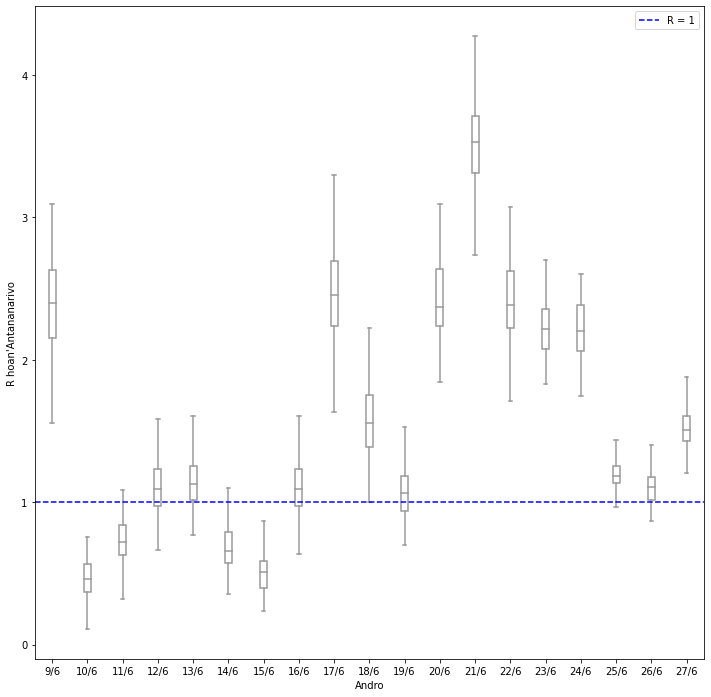

In [26]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(12, 12))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'Antananarivo")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt96276_anta.png')
plt.savefig(path_to_save+'Rt96276_anta.eps')
plt.show()

## Herinandro voalohany

In [106]:
daty_ambaj = datetime.date(2020,6,14)
daty_amboj = datetime.date(2020,6,17)

daty_data_mifarj = datetime.date(2020,6,13)

In [107]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-06-14 : 0.6876876474163751
75%-kartily R : : 0.7872828799175844
25%-kartily R : 0.5747808866018158
Tombana ambony: R 2020-06-17 : 2.4797044117300278
75%-kartily R : : 2.6819367707980324
25%-kartily R : 2.2632961790093638


### Manaikaky avy aty ambany

In [108]:
# Computing Ivao(daty_mifarj + i) for i in a given range

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [109]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Manakaiky avy aty ambony

In [111]:
# Computing Ivao(daty_mifarj + i) for i in a given range

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = (Rt_salan(datetime.date(2020,6,18)) - Rt_salan(daty_amboj))/2
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [112]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


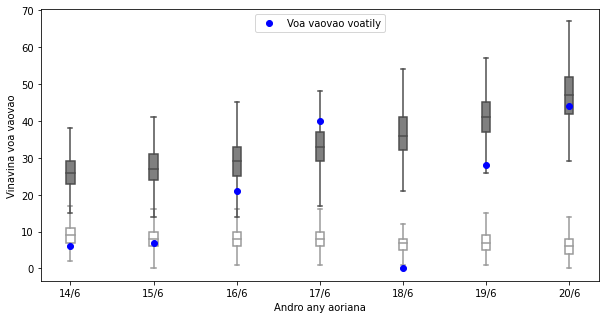

In [114]:
# Plotting

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro any aoriana', ylabel="Vinavina voa vaovao")

plt.legend(loc= 'upper center')

plt.savefig(path_to_save+'Iv146206j_anta.eps')
plt.savefig(path_to_save+'Iv146206j_anta.png')

plt.show()

## Herinandro faharoa

In [99]:
daty_ambaj = datetime.date(2020,6,24)
daty_amboj = datetime.date(2020,6,21)

daty_data_mifarj = datetime.date(2020,6,19)

In [100]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-06-24 : 1.8216780964089148
75%-kartily R : : 1.9563866003811932
25%-kartily R : 1.6784726643511516
Tombana ambony: R 2020-06-21 : 1.8124768643487161
75%-kartily R : : 1.9658015002416271
25%-kartily R : 1.647969619707551


### Manakaiky avy aty ambany

In [101]:
# Computing Ivao(daty_mifarj + i) for i in a given range

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = (Rt_salan(datetime.date(2020,6,25)) - Rt_salan(daty_ambaj))/2
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,9):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [102]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,9):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Manakaiky avy aty ambony

In [77]:
# Computing Ivao(daty_mifarj + i) for i in a given range

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = 0-0.5
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,9):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [78]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,9):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


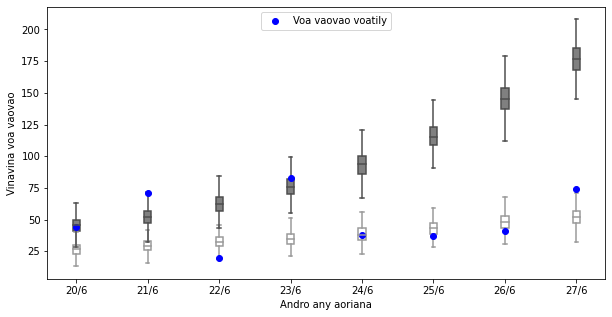

In [104]:
# Plotting

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 7))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro any aoriana', ylabel="Vinavina voa vaovao")

plt.legend(loc= 'upper center')

plt.savefig(path_to_save+'Iv206276j_anta.eps')
plt.savefig(path_to_save+'Iv206276j_anta.png')

plt.show()